In [118]:
import matplotlib.pyplot as plt
import numpy as np
import zipfile
from PIL import Image
import cv2
import os

### Path to zip folder
#zip_path = "C:/Users/Sven Jacob/Downloads/Video_006.zip"
zip_path = "/home/sven/Downloads/Video_007.zip"

img_folder = "Video_007/Video_007/"

with zipfile.ZipFile(zip_path, 'r') as zip_file:
    file_names = zip_file.namelist()
    print(file_names)
    png_files = [f for f in file_names if f.startswith("Video_007/Video_007/Img") and f.lower().endswith(".bmp")]
    png_files = np.sort(png_files)
    #print(png_files)
    frames = []
    for png in png_files:
        with zip_file.open(png) as file:
            image_bytes = file.read()
            image_array = np.frombuffer(image_bytes, dtype=np.uint8)
            image = cv2.imdecode(image_array, cv2.IMREAD_GRAYSCALE)
            frames.append(image)

['Video_007/', 'Video_007/Video_007/', 'Video_007/Video_007.avi', 'Video_007/Video_007.xml', 'Video_007/Video_007/Img_00120.bmp', 'Video_007/Video_007/Img_00121.bmp', 'Video_007/Video_007/Img_00122.bmp', 'Video_007/Video_007/Img_00123.bmp', 'Video_007/Video_007/Img_00124.bmp', 'Video_007/Video_007/Img_00165.bmp', 'Video_007/Video_007/Img_00166.bmp', 'Video_007/Video_007/Img_00167.bmp', 'Video_007/Video_007/Img_00168.bmp', 'Video_007/Video_007/Img_00169.bmp', 'Video_007/Video_007/Img_00257.bmp', 'Video_007/Video_007/Img_00258.bmp', 'Video_007/Video_007/Img_00259.bmp', 'Video_007/Video_007/Img_00260.bmp', 'Video_007/Video_007/Img_00261.bmp', 'Video_007/Video_007/Img_00262.bmp', 'Video_007/Video_007/Img_00263.bmp', 'Video_007/Video_007/Img_00277.bmp', 'Video_007/Video_007/Img_00278.bmp', 'Video_007/Video_007/Img_00279.bmp', 'Video_007/Video_007/Img_00280.bmp', 'Video_007/Video_007/Img_00281.bmp', 'Video_007/Video_007/Img_00282.bmp', 'Video_007/Video_007/Img_00283.bmp', 'Video_007/Video_00

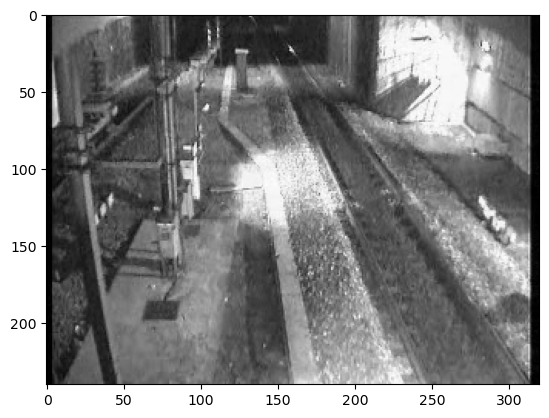

In [119]:
plt.imshow(frames[75],cmap='gray')

In [3]:
M = np.vstack([f.flatten() for f in frames])
M.shape

(86, 76800)

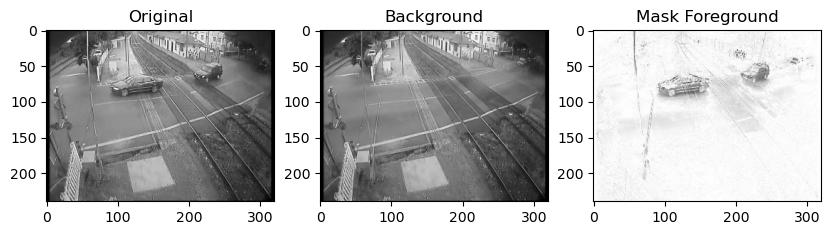

In [4]:
U,s,Vt = np.linalg.svd(M,full_matrices=False)
L=1
S_truncated = np.zeros_like(s)
S_truncated[:L] = s[:L]


frame = 70
M_background = U @ np.diag(S_truncated) @ Vt 
background_frames = M_background.reshape((-1, frames[0].shape[0],frames[0].shape[1]))
fig,ax = plt.subplots(1,3,figsize=(10,10))
ax[1].imshow(background_frames[frame],cmap='gray')
ax[1].set_title('Background')
ax[0].imshow(frames[frame],cmap='gray');
ax[0].set_title('Original')
ax[2].imshow(np.abs(frames[frame]-background_frames[frame]),cmap='binary');
ax[2].set_title('Mask Foreground');

## Yolo 11 no attack

In [136]:
np.random.randint(-1, 2, (3,3,3)).min()

-1

In [5]:
from ultralytics import YOLO
from torchvision import transforms
import torch

# Load a pretrained YOLO11n model
model = YOLO("yolo11n.pt")

frame=1

## need to resize it such that w and h is divisible by 32 and has 3 channels
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((480,640)) # Resize to model's expected input size
])

img_tensor = transform(frames[frame]).unsqueeze(0) 

img_tensor = torch.stack((img_tensor.squeeze(0),)*3,dim=1)


# Run inference on the source
results = model(img_tensor,show=True)
cv2.waitKey(0)
cv2.destroyAllWindows() # list of Results objects


0: 480x640 1 person, 1 car, 48.8ms
Speed: 1.2ms preprocess, 48.8ms inference, 150.8ms postprocess per image at shape (1, 3, 480, 640)


In [6]:
from torchvision.ops import box_iou as IOU
from torchvision.ops import generalized_box_iou_loss as LossGIOU
from torchvision.ops import generalized_box_iou as GIOU

In [8]:
import torch 
import torch.nn as nn
from torchvision.ops import box_iou as IOU
from torch.optim import SGD

class IOU_Loss(nn.Module):
    def __init__(self):
        super(IOU_Loss,self).__init__()

    def iou_loss(self,box1, box2):
        ious = IOU(box1, box2)  # (N, M)
        max_ious, _ = torch.max(ious, dim=1) # (N,)
        loss = 1 - torch.mean(max_ious)
        return loss
    
    def forward(self,prediction,target):
        return self.iou_loss(target,prediction)
    

In [116]:
def iou_loss(box1, box2):
    """
    Calculates IoU loss between two sets of bounding boxes.

    Args:
        box1: (N, 4) tensor, where each row is [x1, y1, x2, y2].
        box2: (M, 4) tensor, where each row is [x1, y1, x2, y2].

    Returns:
        A scalar tensor representing the IoU loss.
    """
    ious = IOU(box1, box2)  # (N, M)
    # Example loss: Max IoU for each box in box1
    max_ious, _ = torch.max(ious, dim=1) # (N,)
    loss = 1 - torch.mean(max_ious) # or any other loss function you like.
    return loss

In [9]:
SIZE = frames[0].shape

In [ ]:
Delta = torch.rand(SIZE,requires_grad=True)
optimizer = SGD([Delta],lr=0.001,momentum=0.1)


epochs = 20

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((480,640)) # Resize to model's expected input size
])



for e in epochs:
    optimizer.zero_grad()
    for frame in frames:
        img_tensor = transform(frames[frame]).unsqueeze(0)
        img_tensor = torch.stack((img_tensor.squeeze(0),)*3,dim=1)

        




torch.Size([1, 3, 640, 640])
#########################
tensor(-2299.7710, device='cuda:0', grad_fn=<AddBackward0>)
Step [1/20], Avg IoU Loss: -20.90700912475586
#########################
tensor(-565.8258, device='cuda:0', grad_fn=<AddBackward0>)
Step [2/20], Avg IoU Loss: -5.143870830535889
#########################
tensor(-437.5861, device='cuda:0', grad_fn=<AddBackward0>)
Step [3/20], Avg IoU Loss: -3.978055238723755
#########################
tensor(-345.3755, device='cuda:0', grad_fn=<AddBackward0>)
Step [4/20], Avg IoU Loss: -3.1397767066955566
#########################
tensor(-276.6382, device='cuda:0', grad_fn=<AddBackward0>)
Step [5/20], Avg IoU Loss: -2.514892339706421
#########################
tensor(-218.2914, device='cuda:0', grad_fn=<AddBackward0>)
Step [6/20], Avg IoU Loss: -1.984467625617981
#########################
tensor(-173.3117, device='cuda:0', grad_fn=<AddBackward0>)
Step [7/20], Avg IoU Loss: -1.5755610466003418
#########################
tensor(-132.7479, device=

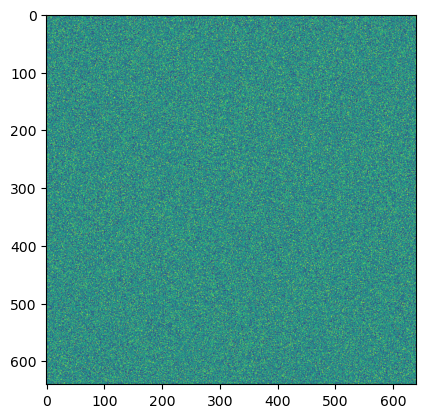

In [126]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.random
from torchvision.ops import box_iou as IOU
import torchvision.transforms as transforms

# Load YOLO model (fixed during attack)
yolo_model = YOLO("yolo11n.pt").eval()

# IoU Loss Function
class IOU_Loss(nn.Module):
    def __init__(self):
        super(IOU_Loss, self).__init__()

    def iou_loss(self, box1, box2):
        if box1.size(0) == 0 and box2.size(0) != 0:
            return torch.tensor(1.0, device=box1.device,requires_grad=True)  # Max loss (worst-case scenario)
        elif box1.size(0) == 0 and box2.size(0) == 0:
            return torch.tensor(0.0, device=box1.device,requires_grad=True)
        elif box1.size(0) != 0 and box2.size(0) == 0:
            return torch.tensor(1.0, device=box1.device,requires_grad=True)
        
        ious = IOU(box1, box2)  # (N, M)
        max_ious, _ = torch.max(ious, dim=1)  # (N,)
        loss = 1 - torch.mean(max_ious)
        return loss

    def forward(self, prediction, target):
        return self.iou_loss(prediction,target)

def nuclear_norm(x):
    return torch.mean(torch.norm(x.squeeze(0), p='nuc', dim=(1, 2)))


def frobenius_norm(x):
    return torch.mean(torch.norm(x.squeeze(0), p='fro', dim=(1, 2))**2)

def l1_norm(x):
    return torch.mean(torch.norm(x.squeeze(0), p=1, dim=(1, 2)))

YOLO_INPUT_H = 640
YOLO_INPUT_W = 640



preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((YOLO_INPUT_H,YOLO_INPUT_W))
])


epsilon = 0.2  # L-inf 0.2
num_steps = 20  # epochs
alpha = 0.05  # Step size
l1 = 100 #vorher 100
l2 = 100
l3 = 50

universal_perturbation = torch.rand((1, 3, YOLO_INPUT_H, YOLO_INPUT_W), device="cuda", requires_grad=True)
plt.imshow(universal_perturbation.squeeze(0).mean(axis=0).detach().cpu().numpy())
print(universal_perturbation.shape)

#optimizer = optim.SGD([universal_perturbation], lr=alpha,momentum=0.7)

optimizer = optim.Adagrad([universal_perturbation], lr=alpha)

image_list = frames 

iou_loss_fn = IOU_Loss()

# Universal Adversarial Attack (Optimize Shared Perturbation)
for step in range(num_steps):
    print("#########################")
    optimizer.zero_grad()
    total_loss = 0.0

    for image in image_list[:50]:
        # Preprocess Image
        image_tensor = preprocess(image).unsqueeze(0).to("cuda")
        image_tensor = torch.stack((image_tensor.squeeze(0),)*3,dim=1)

        
        # Add Universal Perturbation (clamp to keep it valid)
        adv_image = torch.clamp(image_tensor + universal_perturbation, 0, 1)

        with torch.no_grad():
            pred_box = yolo_model(adv_image,verbose=False)[0]
        pred_box_xyxy = pred_box.boxes.xyxy
        true_pred = yolo_model(image_tensor,verbose=False)
        target_box_xyxy = true_pred[0].boxes.xyxy


        loss = iou_loss_fn(pred_box_xyxy, target_box_xyxy)
        #total_loss += loss + l1*nuclear_norm(universal_perturbation)/(YOLO_INPUT_H*YOLO_INPUT_W) + l2*frobenius_norm(universal_perturbation)/(YOLO_INPUT_H*YOLO_INPUT_W)
        #test 1
        #total_loss += loss - l1*(nuclear_norm(adv_image)/(YOLO_INPUT_H*YOLO_INPUT_W)-nuclear_norm(image_tensor)/(YOLO_INPUT_H*YOLO_INPUT_W))\
                             # - l2*(frobenius_norm(adv_image)-frobenius_norm(image_tensor))/(YOLO_INPUT_H*YOLO_INPUT_W)\
                             # - l3*l1_norm(universal_perturbation)/(YOLO_INPUT_H*YOLO_INPUT_W)

        #test 2
        total_loss += loss - l1*(nuclear_norm(adv_image)/(YOLO_INPUT_H*YOLO_INPUT_W)-nuclear_norm(image_tensor)/(YOLO_INPUT_H*YOLO_INPUT_W))\
                                - l2*frobenius_norm(adv_image-image_tensor)/(YOLO_INPUT_H*YOLO_INPUT_W)\
                                - l3*l1_norm(universal_perturbation)/(YOLO_INPUT_H*YOLO_INPUT_W)

    # Average Loss Over All Images
    print(total_loss)
    avg_loss = total_loss / len(image_list)

    # Backpropagate to maximize loss
    (-avg_loss).backward()
    optimizer.step()
    #print(universal_perturbation.grad)
    #pertub = 0.1* universal_perturbation.grad.sign()

    # Ensure Perturbation is Within Allowed Range
    universal_perturbation.data = torch.clamp(universal_perturbation.data, -epsilon, epsilon)
    #universal_perturbation.data = torch.clamp(universal_perturbation.data + pertub, 0, 1)


    print(f"Step [{step+1}/{num_steps}], Avg IoU Loss: {avg_loss.item()}")


In [86]:
universal_perturbation.squeeze(0).mean(axis=0).max()

tensor(0.0522, device='cuda:0', grad_fn=<MaxBackward1>)

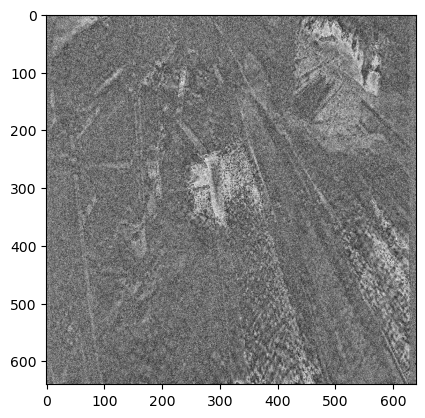

In [127]:

plt.imshow(universal_perturbation.squeeze(0).mean(axis=0).detach().cpu().numpy(),cmap='binary')

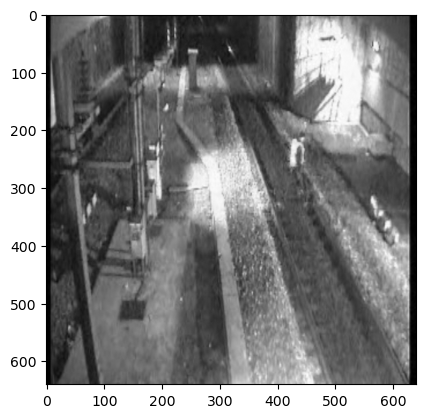

In [128]:
plt.imshow(torch.clamp(universal_perturbation.detach().cpu()+img_tensor,0,1).squeeze(0).mean(axis=0).numpy(),cmap='gray')

In [131]:
frame=30
## need to resize it such that w and h is divisible by 32 and has 3 channels
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((640,640)) # Resize to model's expected input size
])

img_tensor = transform(frames[frame]).unsqueeze(0) 

img_tensor = torch.stack((img_tensor.squeeze(0),)*3,dim=1)


# Run inference on the source
results = model(img_tensor,show=True)
cv2.waitKey(0)
cv2.destroyAllWindows()


0: 640x640 (no detections), 7.0ms
Speed: 0.6ms preprocess, 7.0ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)


In [130]:
pertubed_img = torch.clamp(img_tensor+universal_perturbation.detach().cpu(),0,1)
results = model(pertubed_img,show=True)
cv2.waitKey(0)
cv2.destroyAllWindows()


0: 640x640 (no detections), 9.5ms
Speed: 0.5ms preprocess, 9.5ms inference, 6.6ms postprocess per image at shape (1, 3, 640, 640)


torch.Size([1, 3, 480, 640])
#########################
tensor(0., device='cuda:0', grad_fn=<AddBackward0>)
Step [1/15], Avg IoU Loss: 0.0
#########################
tensor(2.0775, device='cuda:0', grad_fn=<AddBackward0>)
Step [2/15], Avg IoU Loss: 0.024157369509339333
#########################
tensor(0., device='cuda:0', grad_fn=<AddBackward0>)
Step [3/15], Avg IoU Loss: 0.0
#########################
tensor(2.0775, device='cuda:0', grad_fn=<AddBackward0>)
Step [4/15], Avg IoU Loss: 0.024157369509339333
#########################


KeyboardInterrupt: 

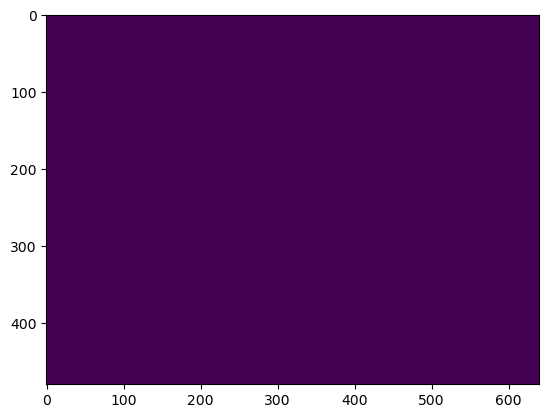

In [61]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.random
from torchvision.ops import box_iou as IOU
import torchvision.transforms as transforms

# Load YOLO model (fixed during attack)
yolo_model = YOLO("yolo11n.pt").eval()

# IoU Loss Function
class IOU_Loss(nn.Module):
    def __init__(self):
        super(IOU_Loss, self).__init__()

    def iou_loss(self, box1, box2):
        if box1.size(0) == 0 and box2.size(0) != 0:
            return torch.tensor(1.0, device=box1.device,requires_grad=True)  # Max loss (worst-case scenario)
        elif box1.size(0) == 0 and box2.size(0) == 0:
            return torch.tensor(0.0, device=box1.device,requires_grad=True)
        elif box1.size(0) != 0 and box2.size(0) == 0:
            return torch.tensor(1.0, device=box1.device,requires_grad=True)
        
        ious = IOU(box1, box2)  # (N, M)
        max_ious, _ = torch.max(ious, dim=1)  # (N,)
        loss = 1 - torch.mean(max_ious)
        return loss

    def forward(self, prediction, target):
        return self.iou_loss(prediction,target)

def nuclear_norm(x):
    return torch.mean(torch.norm(x.squeeze(0), p='nuc', dim=(1, 2)))


def frobenius_norm(x):
    return torch.mean(torch.norm(x.squeeze(0), p='fro', dim=(1, 2))**2)

def l1_norm(x):
    return torch.mean(torch.norm(x.squeeze(0), p=1, dim=(1, 2)))

YOLO_INPUT_H = 480
YOLO_INPUT_W = 640



preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((YOLO_INPUT_H,YOLO_INPUT_W))
])


epsilon = 0.1 # L-inf 0.2
num_steps = 15  # epochs
alpha = 0.01  # Step size
l1 = 10
l2 = 10

universal_perturbation = torch.zeros((1, 3, YOLO_INPUT_H, YOLO_INPUT_W), device="cuda", requires_grad=True)
plt.imshow(universal_perturbation.squeeze(0).mean(axis=0).detach().cpu().numpy())
print(universal_perturbation.shape)

#optimizer = optim.SGD([universal_perturbation], lr=alpha,momentum=0.7)

#optimizer = optim.Adagrad([universal_perturbation], lr=alpha)

image_list = frames 

iou_loss_fn = IOU_Loss()

# Universal Adversarial Attack (Optimize Shared Perturbation)
for step in range(num_steps):
    print("#########################")
    #optimizer.zero_grad()
    total_loss = 0.0

    for image in image_list:
        # Preprocess Image
        image_tensor = preprocess(image).unsqueeze(0).to("cuda")
        image_tensor = torch.stack((image_tensor.squeeze(0),)*3,dim=1)

        
        # Add Universal Perturbation (clamp to keep it valid)
        adv_image = torch.clamp(image_tensor + universal_perturbation, 0, 1)

        with torch.no_grad():
            pred_box = yolo_model(adv_image,verbose=False)[0]
        pred_box_xyxy = pred_box.boxes.xyxy
        true_pred = yolo_model(image_tensor,verbose=False)
        target_box_xyxy = true_pred[0].boxes.xyxy


        loss = iou_loss_fn(pred_box_xyxy, target_box_xyxy)
        total_loss += loss + l1*nuclear_norm(universal_perturbation)/(YOLO_INPUT_H*YOLO_INPUT_W) + l2*frobenius_norm(universal_perturbation)/(YOLO_INPUT_H*YOLO_INPUT_W)

    # Average Loss Over All Images
    print(total_loss)
    avg_loss = total_loss / len(image_list)

    # Backpropagate to maximize loss
    (-avg_loss).backward()
    #optimizer.step()
    #pertub = 0.1* universal_perturbation.grad.sign()

    with torch.no_grad():
        universal_perturbation += epsilon * universal_perturbation.grad.sign()
        universal_perturbation.data = torch.clamp(universal_perturbation.data, -epsilon, epsilon)  # Keep perturbation small
    # Ensure Perturbation is Within Allowed Range
    #universal_perturbation.data = torch.clamp(universal_perturbation.data, -epsilon, epsilon)
    #universal_perturbation.data = torch.clamp(universal_perturbation.data + pertub, 0, 1)


    print(f"Step [{step+1}/{num_steps}], Avg IoU Loss: {avg_loss.item()}")


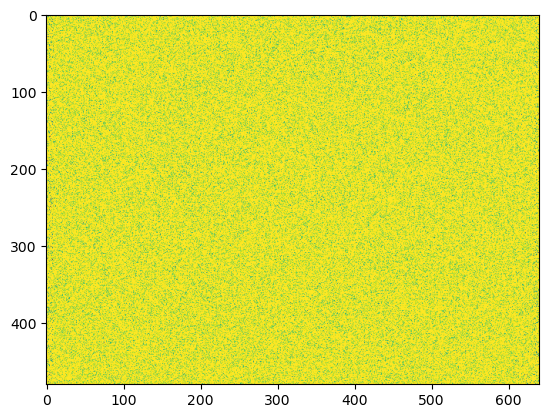

In [9]:
plt.imshow(universal_perturbation.squeeze(0).mean(axis=0).detach().cpu().numpy())

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.ops import box_iou as IOU

yolo_model = YOLO('yolo11n.pt')

class AdversarialTrackingLoss(nn.Module):
    def __init__(self, lambda_1=1.0, lambda_2=0.5, lambda_3=0.2):
        """
        Adversarial loss function for object tracking.
        :param lambda_1: Weight for IoU loss
        :param lambda_2: Weight for confidence loss
        :param lambda_3: Weight for center deviation loss
        """
        super(AdversarialTrackingLoss, self).__init__()
        self.lambda_1 = lambda_1
        self.lambda_2 = lambda_2
        self.lambda_3 = lambda_3

    def iou_loss(self, pred_boxes_res, target_boxes_res):
        pred_boxes=pred_boxes_res.xyxy
        target_boxes=target_boxes_res.xyxy
        """ Compute IoU loss (1 - max IoU) to encourage misalignment. """
        if target_boxes.size(0) == 0:  
            return torch.tensor(1.0, device=pred_boxes.device, requires_grad=True)  # Max loss when no objects exist
        elif pred_boxes.size(0) == 0:
            return torch.tensor(1.0, device=pred_boxes.device, requires_grad=True)  # Max loss if no predictions exist
        
        ious = IOU(pred_boxes, target_boxes)  # Compute IoU
        max_ious, _ = torch.max(ious, dim=1)  # Get highest IoU per prediction
        return 1 - torch.mean(max_ious)  # Adversarial: Higher loss = worse tracking

    def confidence_loss(self, pred_boxes_res):

        """ Encourage high confidence in false detections when no objects exist. """
        return -torch.mean(pred_boxes_res.conf) if pred_boxes_res is not None and len(pred_boxes_res.xyxy) > 0 else 0.0

    def center_deviation_loss(self, pred_boxes_res, target_boxes_res):
        """ Penalize large shifts in predicted bounding box centers. """
        pred_boxes=pred_boxes_res.xyxy
        target_boxes = target_boxes_res.xyxy
        if target_boxes.size(0) == 0 or pred_boxes.size(0) == 0:
            return torch.tensor(0.0, device=pred_boxes.device, requires_grad=True)
        
        pred_centers = (pred_boxes[:, :2] + pred_boxes[:, 2:]) / 2  # (x_center, y_center)
        target_centers = (target_boxes[:, :2] + target_boxes[:, 2:]) / 2
        
        return torch.mean(torch.norm(pred_centers - target_centers, p=2, dim=1))  # L2 distance between centers

    def forward(self, pred_boxes, target_boxes):
        """
        Compute adversarial loss for tracking.
        :param pred_boxes: Predicted bounding boxes from adversarial image.
        :param target_boxes: Ground-truth bounding boxes from clean image.
        :return: Loss value to optimize adversarial perturbation.
        """
        # Adaptive weighting: If no target boxes, encourage false positives
        w_target = 1.0 if target_boxes.xyxy.size(0) > 0 else 0.0
        empty_loss = self.confidence_loss(pred_boxes)  # Encourage high false-positive confidence

        # Compute adversarial loss
        total_loss = (
            w_target * (
                self.lambda_1 * self.iou_loss(pred_boxes, target_boxes) +
                self.lambda_2 * self.confidence_loss(pred_boxes) #self.lambda_3 * self.center_deviation_loss(pred_boxes, target_boxes)
            ) + (1 - w_target) * empty_loss
        )

        return total_loss

# Initialize loss function
adv_loss_fn = AdversarialTrackingLoss(lambda_1=200,lambda_2=20)

# Adversarial perturbation (trainable)
universal_perturbation = torch.randn((1, 3, 480, 640), device="cuda", requires_grad=True)

# Optimizer (FGSM-like update)
optimizer = optim.Adam([universal_perturbation], lr=0.0001)

epsilon = 0.1
for step in range(num_steps):
    optimizer.zero_grad()
    total_loss = 0.0

    for image in image_list:
        image_tensor = preprocess(image).unsqueeze(0).to("cuda")
        image_tensor = torch.stack((image_tensor.squeeze(0),)*3,dim=1)


        # Add adversarial perturbation
        adv_image = torch.clamp(image_tensor + universal_perturbation, 0, 1)

        # Get YOLO predictions
        with torch.no_grad():
            pred_boxes = yolo_model(adv_image, verbose=False)[0].boxes
            target_boxes = yolo_model(image_tensor, verbose=False)[0].boxes

        # Compute adversarial loss
        loss = adv_loss_fn(pred_boxes, target_boxes)
        total_loss += loss

    # Average loss
    avg_loss = total_loss / len(image_list)

    # Backprop to optimize adversarial perturbation
    (avg_loss).backward()
    optimizer.step()

    # Ensure perturbation stays within allowed range
    universal_perturbation.data = torch.clamp(universal_perturbation.data, -epsilon, epsilon)

    print(f"Step [{step+1}/{num_steps}], Avg Adversarial Loss: {avg_loss.item()}")

Step [1/15], Avg Adversarial Loss: 195.3488311767578
Step [2/15], Avg Adversarial Loss: 116.5092544555664
Step [3/15], Avg Adversarial Loss: 116.5092544555664
Step [4/15], Avg Adversarial Loss: 116.5092544555664
Step [5/15], Avg Adversarial Loss: 116.5092544555664
Step [6/15], Avg Adversarial Loss: 116.5092544555664
Step [7/15], Avg Adversarial Loss: 116.5092544555664
Step [8/15], Avg Adversarial Loss: 116.5092544555664
Step [9/15], Avg Adversarial Loss: 116.5092544555664
Step [10/15], Avg Adversarial Loss: 116.5092544555664
Step [11/15], Avg Adversarial Loss: 116.5092544555664
Step [12/15], Avg Adversarial Loss: 116.5092544555664
Step [13/15], Avg Adversarial Loss: 116.5092544555664
Step [14/15], Avg Adversarial Loss: 116.5092544555664
Step [15/15], Avg Adversarial Loss: 116.5092544555664


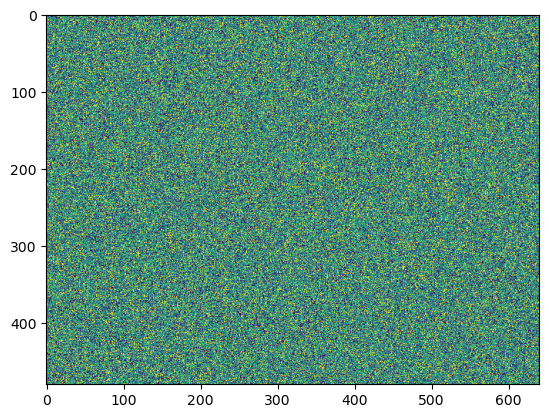

In [113]:
plt.imshow(universal_perturbation.squeeze(0).mean(axis=0).detach().cpu().numpy())

In [16]:
frame=50

## need to resize it such that w and h is divisible by 32 and has 3 channels
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((480,640)) # Resize to model's expected input size
])

img_tensor = transform(frames[frame]).unsqueeze(0) 

img_tensor = torch.stack((img_tensor.squeeze(0),)*3,dim=1)


# Run inference on the source
results = model(img_tensor,show=True)
cv2.waitKey(0)
cv2.destroyAllWindows()


0: 480x640 5 cars, 6.0ms
Speed: 0.4ms preprocess, 6.0ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)


In [14]:
pertubed_img = torch.clamp(img_tensor+universal_perturbation.detach().cpu(),0,1)

In [15]:
results = model(pertubed_img,show=True)
cv2.waitKey(0)
cv2.destroyAllWindows()


0: 480x640 4 cars, 1 sink, 8.5ms
Speed: 0.4ms preprocess, 8.5ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 640)


In [271]:
pertubed_img.max()

tensor(1.0713)

## Attacks on max singular value

In [129]:
pred_box[0].boxes.xyxy

tensor([[484.6473,  95.9969, 498.8666, 132.4690],
        [552.5139,  77.8668, 578.2626, 101.5728]], device='cuda:0')

[ 3.4738e+05           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0
           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0
           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0
           0           0           0           0           0 

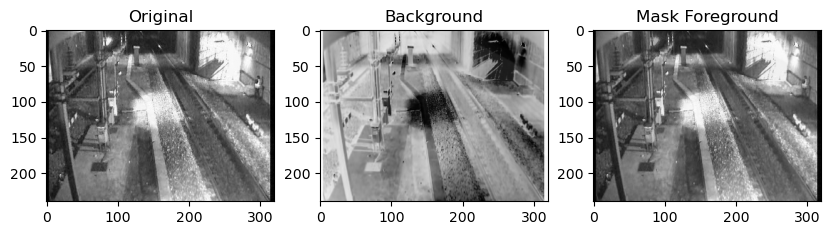

In [205]:
U,s,Vt = np.linalg.svd(M,full_matrices=False)
L=0
S_truncated = np.zeros_like(s)
S_truncated[L:L+1] = s[L:L+1]

S_truncated[0] = S_truncated[0].copy()
print(S_truncated)
U = U.copy() + np.random.uniform(0,0.2,U.shape)
#Vt = Vt.copy() + np.random.normal(0,0.001,Vt.shape)


frame = 65
M_background = U @ np.diag(S_truncated) @ Vt 
background_frames = M_background.reshape((-1, frames[0].shape[0],frames[0].shape[1]))
fig,ax = plt.subplots(1,3,figsize=(10,10))
ax[1].imshow(background_frames[frame],cmap='gray')
ax[1].set_title('Background')
ax[0].imshow(frames[frame],cmap='gray');
ax[0].set_title('Original')
ax[2].imshow(np.abs(frames[frame]-background_frames[frame]),cmap='gray');
ax[2].set_title('Mask Foreground');


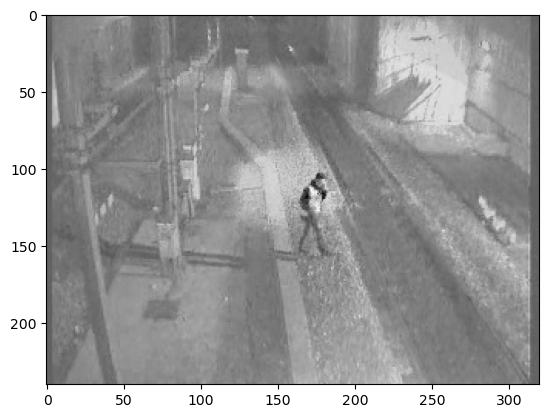

In [200]:
Attack_frame =  frames[frame] +background_frames[frame] 

plt.imshow(Attack_frame,cmap='gray')

In [206]:
Attack_frame =  frames[frame] +background_frames[frame] 


img_tensor = transform(Attack_frame).unsqueeze(0) 

img_tensor = torch.stack((img_tensor.squeeze(0),)*3,dim=1)


# Run inference on the source
results = model(img_tensor,show=True)
cv2.waitKey(0)
cv2.destroyAllWindows() # list of Results ob


WARNING  torch.Tensor inputs should be normalized 0.0-1.0 but max value is 226.18721928770606. Dividing input by 255.
0: 480x640 1 person, 188.8ms
Speed: 2.3ms preprocess, 188.8ms inference, 28.4ms postprocess per image at shape (1, 3, 480, 640)


In [4]:
from ao_exp_grad import AOExpGrad,fmin
from ao_exp_ftrl import fmin as fmin_ftrl

from ao_grad import fmin as fmin_aograd


In [5]:
from scipy.linalg import norm

In [8]:
M_normalized = (M/255)-0.5

In [9]:
def loss(X):
    l = 0
    for frame in M_normalized:
        tmp = frame.reshape(SIZE).copy()
        l+=np.linalg.norm(X-tmp)**2
    return 0.5*l/frame.shape[0] + 1*norm(X,ord='nuc') + 0.001*norm(X,ord='fro')


def loss_grad(X):
    l = 0 
    for frame in M_normalized:
        tmp = frame.reshape(SIZE).copy()
        l+=X-tmp
    return l/frame.shape[0]

320

In [10]:
def callback(res):
    print(res.func)

In [11]:
x_int = np.mean(M,axis=0).reshape(SIZE)
print(loss(x_int))
print(loss_grad(x_int))
Result = fmin(loss,loss_grad,x_int,lower=-0.5,upper=0.5,eta=1,maxfev=100,l1=150,l2=1,callback=callback,epoch_size=1)
Result

880705.5873919487
[[0.01065099 0.00690273 0.00202609 ... 0.00539823 0.00561872 0.00539823]
 [0.00709727 0.00414017 0.00354356 ... 0.00506102 0.00538526 0.00546308]
 [0.00787546 0.00731776 0.00241519 ... 0.00500914 0.0055409  0.00559278]
 ...
 [0.00273943 0.00325822 0.0036084  ... 0.00738261 0.00759012 0.00746043]
 [0.00260973 0.00362137 0.00292101 ... 0.00842019 0.00976905 0.00848504]
 [0.00259676 0.00323228 0.00320634 ... 0.00971717 0.01019705 0.01018408]]


c:\Users\Sven Jacob\Documents\Github\MatrixAdvAttacks\ao_exp_grad.py:58: RuntimeWarning: invalid value encountered in log
  x_val = np.where(abc>=15.0,np.log(abc)-np.log(np.log(abc))+np.log(np.log(abc))/np.log(abc), lambertw( np.exp(abc), k=0).real )/b-a


19.13527053093827
8.43370653168641
5.758677422503497
4.688706310580898
4.153729439994717
3.8480309707924456
3.6569703876590247
3.5295970758769144
3.440435952935493
3.3755916009108295
3.3269583927211936
3.2895482651382184
3.260154613330117
3.236639704469616
3.217533849258159
3.2017996211001374
3.1886877681280037
3.1776462104283265
3.168260888323019
3.1602163279369253
3.153268754111725
3.147227386361902
3.1419411901865653
3.1372893380199476
3.133174238391364
3.1295163723424775
3.12625042074187
3.1233223263868726
3.1206870416156867
3.118306784523776
3.1161496766332464
3.114188669541732
3.112400692555516
3.1107659707961464
3.109267475897555
3.1078904806253953
3.106622195540238
3.1054514708751313
3.104368550584597
3.1033648683852895
3.1024328777898966
3.10156590980996
3.1007580532968877
3.1000040538966003
3.099299228380648
3.0986393917365236
3.098020794890658
3.0974400713281165
3.096894191185546
3.0963804216451085
3.0958962926599636
3.095439567206631
3.095008215393468
3.0946003918644864
3.0

 success: True
       x: (array([[ 3.552e-07,  1.977e-07, ...,  8.539e-08,  7.545e-08],
                 [ 1.523e-07,  2.533e-08, ..., -1.162e-08, -2.133e-08],
                 ...,
                 [-5.651e-08, -8.275e-09, ...,  4.312e-08,  1.184e-08],
                 [-5.463e-08, -1.708e-08, ...,  8.512e-08,  6.231e-08]]), array([ 0.000e+00,  0.000e+00, ...,  0.000e+00,  0.000e+00]), array([[ 1.329e-01,  1.746e-02, ...,  2.729e-03,  3.130e-03],
                 [ 5.692e-02,  6.657e-02, ..., -3.843e-04,  3.011e-03],
                 ...,
                 [ 4.638e-02, -2.722e-02, ...,  3.084e-01, -1.446e-02],
                 [ 4.579e-02, -2.833e-02, ..., -1.202e-01, -5.827e-04]]), array([[-1.860e-01, -1.864e-01, ..., -1.829e-01, -1.828e-01],
                 [ 6.820e-02,  6.810e-02, ...,  6.611e-02,  6.614e-02],
                 ...,
                 [ 5.361e-02,  3.069e-02, ..., -2.368e-02, -1.448e-02],
                 [ 3.301e-02, -3.637e-02, ...,  2.452e-02, -3.425e-02]]))
     n

In [54]:
x_result,sigma,u,v = Result.x

In [55]:
u_res, s_res, v_res  = np.linalg.svd(x_result,full_matrices=False)

In [56]:
s_res[s_res > np.quantile(s_res,0.5)] = 0
s_res[s_res>0]=1.0

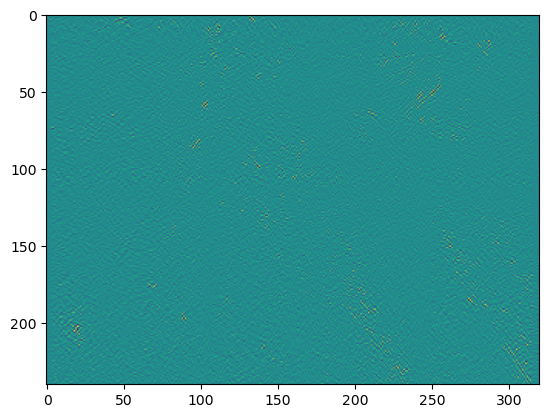

In [57]:
plt.imshow(np.matmul(u_res*s_res[..., None, :], v_res))

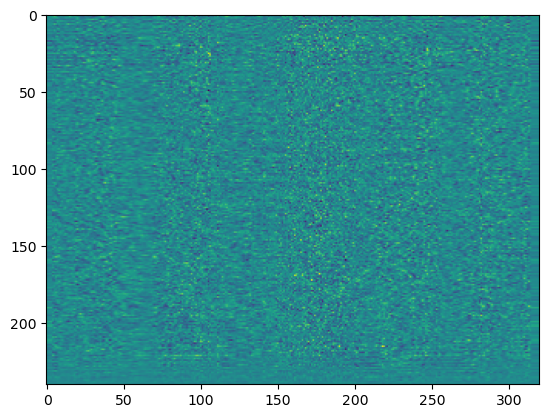

In [55]:
plt.imshow(np.sum([np.matmul(u[i,:][:,np.newaxis],v[i,:][:,np.newaxis].T) for i in range(110)],axis=0))

u 240x240
v 

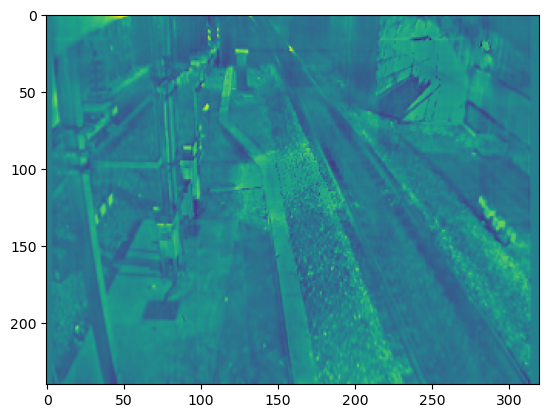

In [61]:
plt.imshow(x_result)

In [ ]:
np.outer()

(240, 320)

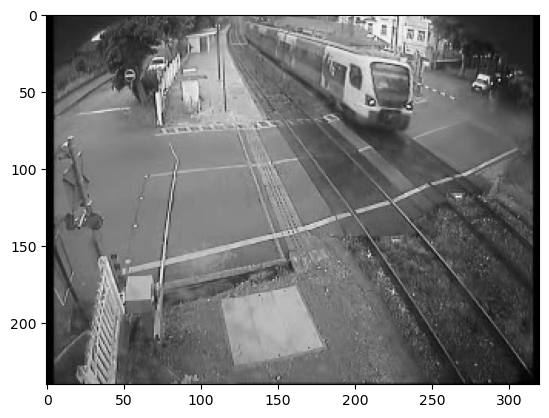

In [170]:
plt.imshow(frames[10],cmap='gray')

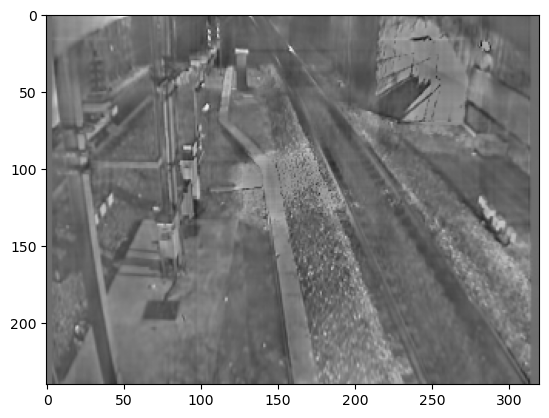

In [18]:
plt.imshow(sigma,cmap='gray')

In [12]:
Result.x

(array([[ 3.55239173e-07,  1.97745869e-07, -3.48479614e-08, ...,
          7.33908495e-08,  8.53860605e-08,  7.54548961e-08],
        [ 1.52316180e-07,  2.53270957e-08, -1.64912896e-08, ...,
         -2.78720398e-08, -1.16215495e-08, -2.13281289e-08],
        [ 1.68207287e-07,  1.58399124e-07, -4.74216986e-08, ...,
         -2.10932469e-08,  7.51725574e-09, -1.56969826e-10],
        ...,
        [-4.76438679e-08, -1.68302212e-08, -8.88233885e-09, ...,
         -4.61788872e-08, -2.64866128e-08, -3.85332683e-08],
        [-5.65054542e-08, -8.27542487e-09, -3.02556326e-08, ...,
          2.03304214e-08,  4.31204796e-08,  1.18387458e-08],
        [-5.46322274e-08, -1.70761757e-08, -3.07075667e-08, ...,
          5.40415802e-08,  8.51218044e-08,  6.23142028e-08]]),
 array([[ 0.13285914,  0.01745845,  0.00375182, ...,  0.0046886 ,
          0.00272907,  0.00312993],
        [ 0.05691986,  0.0665729 ,  0.01107839, ...,  0.00850688,
         -0.00038433,  0.00301134],
        [ 0.06504919,  0.

In [ ]:
np.linalg.svd(Result.x,full_matrices=False)

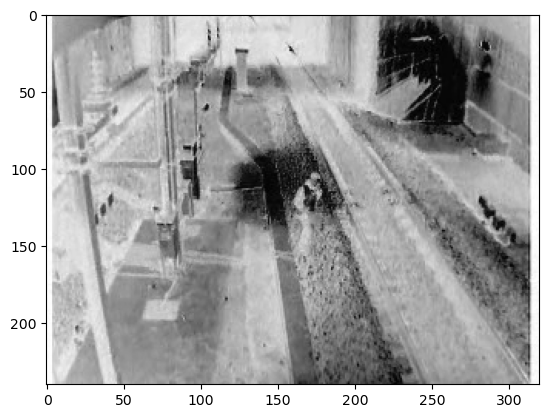

In [208]:
plt.imshow(frames[0]-Result.x,cmap='binary')

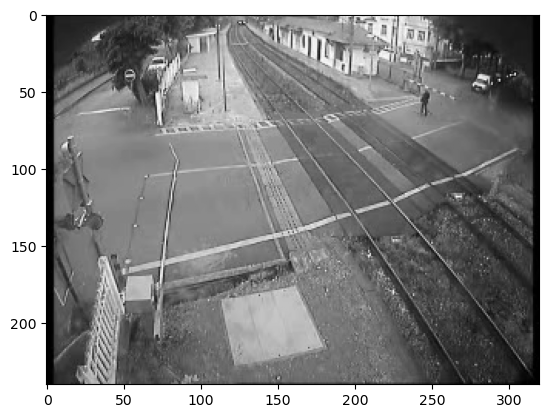

In [185]:
plt.imshow((Result.x-frames[0]),cmap='binary')

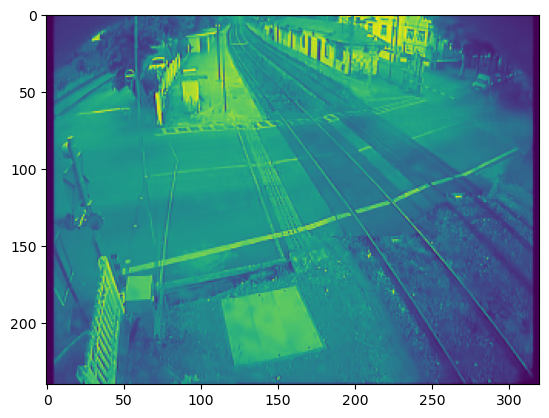

In [155]:
plt.imshow(M.mean(axis=0).reshape(SIZE))

In [44]:
Result.x

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])